In [1]:
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import math

In [2]:
# 配置文件
config = {
    # 训练集文件
    'train_images_idx3_ubyte_file_path': './MNIST/raw/train-images-idx3-ubyte',
    # 训练集标签文件
    'train_labels_idx1_ubyte_file_path': './MNIST/raw/train-labels-idx1-ubyte',

    # 测试集文件
    'test_images_idx3_ubyte_file_path': './MNIST/raw/t10k-images-idx3-ubyte',
    # 测试集标签文件
    'test_labels_idx1_ubyte_file_path': './MNIST/raw/t10k-labels-idx1-ubyte',

    # 特征提取阙值
    'binarization_limit_value': 0.14,
    # 特征提取后的边长
    'side_length': 14
}


In [5]:
def decode_idx3_ubyte(path):
    '''
    解析idx3-ubyte文件，即解析MNIST图像文件
    '''

    '''
    也可不解压，直接打开.gz文件。path是.gz文件的路径
    import gzip
    with gzip.open(path, 'rb') as f:
    '''
    print('loading %s' % path)
    with open(path, 'rb') as f:
        # 前16位为附加数据，每4位为一个整数，分别为幻数，图片数量，每张图片像素行数，列数。
        magic, num, rows, cols = unpack('>4I', f.read(16))
        print('magic:%d num:%d rows:%d cols:%d' % (magic, num, rows, cols))
        mnistImage = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    print('done')
    return mnistImage


def decode_idx1_ubyte(path):
    '''
    解析idx1-ubyte文件，即解析MNIST标签文件
    '''
    print('loading %s' % path)
    with open(path, 'rb') as f:
        # 前8位为附加数据，每4位为一个整数，分别为幻数，标签数量。
        magic, num = unpack('>2I', f.read(8))
        print('magic:%d num:%d' % (magic, num))
        mnistLabel = np.fromfile(f, dtype=np.uint8)
    print('done')
    return mnistLabel


def normalizeImage(image):
    '''
    将图像的像素值正规化为0.0 ~ 1.0
    '''
    res = image.astype(np.float32) / 255.0
    print(res.shape)
    return res


def load_train_images(path=config['train_images_idx3_ubyte_file_path']):
    return normalizeImage(decode_idx3_ubyte(path))


def load_train_labels(path=config['train_labels_idx1_ubyte_file_path']):
    return decode_idx1_ubyte(path)


def load_test_images(path=config['test_images_idx3_ubyte_file_path']):
    return normalizeImage(decode_idx3_ubyte(path))


def load_test_labels(path=config['test_labels_idx1_ubyte_file_path']):
    return decode_idx1_ubyte(path)


def oneImagesFeatureExtraction(image):
    '''
    对单张图片进行特征提取
    '''
    res = np.empty((config['side_length'], config['side_length']))
    num = 28//config['side_length']
    for i in range(0, config['side_length']):
        for j in range(0, config['side_length']):
            # tempMean = (image[2*i:2*(i+1),2*j:2*(j+1)] != 0).sum()/(2 * 2)
            tempMean = image[num*i:num*(i+1), num*j:num*(j+1)].mean()
            if tempMean > config['binarization_limit_value']:
                res[i, j] = 1
            else:
                res[i, j] = 0
    return res


def featureExtraction(images):
    res = np.empty((images.shape[0], config['side_length'],
                    config['side_length']), dtype=np.float32)
    for i in range(images.shape[0]):
        res[i] = oneImagesFeatureExtraction(images[i])
    return res


def bayesModelTrain(train_x, train_y):
    '''
    贝叶斯分类器模型训练
    '''
    # 计算先验概率
    totalNum = train_x.shape[0]
    classNumDic = Counter(train_y)
    prioriP = np.array([classNumDic[i]/totalNum for i in range(10)])

    # 计算类条件概率
    oldShape = train_x.shape
    train_x.resize((oldShape[0], oldShape[1]*oldShape[2]))
    posteriorNum = np.empty((10, train_x.shape[1]))
    posteriorP = np.empty((10, train_x.shape[1]))
    for i in range(10):
        posteriorNum[i] = train_x[np.where(train_y == i)].sum(axis=0)
        # 拉普拉斯平滑
        posteriorP[i] = (posteriorNum[i] + 1) / (classNumDic[i] + 2)
    train_x.resize(oldShape)
    return prioriP, posteriorP


def bayesClassifier(test_x, prioriP, posteriorP):
    '''
    使用贝叶斯分类器进行分类(极大似然估计)
    '''
    oldShape = test_x.shape
    test_x.resize(oldShape[0]*oldShape[1])
    classP = np.empty(10)
    for j in range(10):
        temp = sum([math.log(1-posteriorP[j][x]) if test_x[x] ==
                    0 else math.log(posteriorP[j][x]) for x in range(test_x.shape[0])])
        # 很奇怪，在降维成7*7的时候，注释掉下面这一句正确率反而更高
        classP[j] = np.array(math.log(prioriP[j]) + temp)
        classP[j] = np.array(temp)
    test_x.resize(oldShape)
    return np.argmax(classP)


def modelEvaluation(test_x, test_y, prioriP, posteriorP):
    '''
    对贝叶斯分类器的模型进行评估
    '''
    bayesClassifierRes = np.empty(test_x.shape[0])
    for i in range(test_x.shape[0]):
        bayesClassifierRes[i] = bayesClassifier(test_x[i], prioriP, posteriorP)
    return bayesClassifierRes, (bayesClassifierRes == test_y).sum() / test_y.shape[0]



In [6]:
print('loading MNIST Data')
train_images = load_train_images()
train_labels = load_train_labels()

test_images = load_test_images()
test_labels = load_test_labels()
print('loading done')

loading MNIST Data
loading ./MNIST/raw/train-images-idx3-ubyte
magic:2051 num:60000 rows:28 cols:28
done
(60000, 28, 28)
loading ./MNIST/raw/train-labels-idx1-ubyte
magic:2049 num:60000
done
loading ./MNIST/raw/t10k-images-idx3-ubyte
magic:2051 num:10000 rows:28 cols:28
done
(10000, 28, 28)
loading ./MNIST/raw/t10k-labels-idx1-ubyte
magic:2049 num:10000
done
loading done


[5 0 4 1 9]


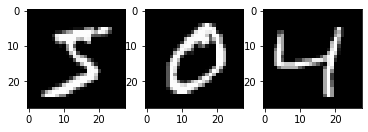

In [26]:
nowMnistLabel = train_labels[0:5].copy()
nowMnistImage = train_images[0:5].copy()
print(nowMnistLabel)
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
# ax4 = plt.subplot(2,5,4)
# ax5 = plt.subplot(2,5,5)
plt.sca(ax1)
plt.imshow(nowMnistImage[0], cmap='gray')
plt.sca(ax2)
plt.imshow(nowMnistImage[1], cmap='gray')
plt.sca(ax3)
plt.imshow(nowMnistImage[2], cmap='gray')
# plt.sca(ax4)
# plt.imshow(nowMnistImage[3], cmap='gray')
# plt.sca(ax5)
# plt.imshow(nowMnistImage[4], cmap='gray')
plt.show()

In [44]:
print('feature extraction start')
train_images_feature = featureExtraction(train_images)
print('feature extraction done')

feature extraction start
feature extraction done


[5 0 4]


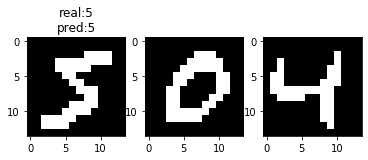

In [45]:
# nowMnistLabel = train_labels[0].copy()
# nowMnistImage = train_images_feature[0].copy()
nowMnistLabel = train_labels[:3].copy()
nowMnistImage = train_images_feature[:3].copy()
print(nowMnistLabel)
# plt.imshow(nowMnistImage, cmap='gray')
# plt.show()
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
ax1.set_title("real:5\npred:5")
# ax4 = plt.subplot(2,5,4)
# ax5 = plt.subplot(2,5,5)
plt.sca(ax1)
plt.imshow(nowMnistImage[0], cmap='gray')
plt.sca(ax2)
plt.imshow(nowMnistImage[1], cmap='gray')
plt.sca(ax3)
plt.imshow(nowMnistImage[2], cmap='gray')
# plt.sca(ax4)
# plt.imshow(nowMnistImage[3], cmap='gray')
# plt.sca(ax5)
# plt.imshow(nowMnistImage[4], cmap='gray')
plt.show()

In [46]:
print('bayes model train start')
prioriP, posteriorP = bayesModelTrain(train_images_feature, train_labels)
print('bayes model train done')
# print(prioriP)
# print(posteriorP)

print('bayes model evaluation start')
test_images_feature = featureExtraction(test_images)
res, val = modelEvaluation(
    test_images_feature, test_labels, prioriP, posteriorP)
print('贝叶斯分类器的准确度为%.2f %%' % (val*100))
print('bayes model evaluation done')
    

bayes model train start
bayes model train done
bayes model evaluation start
贝叶斯分类器的准确度为83.58 %
bayes model evaluation done
